# Fallbacks with Branching Pipelines

In [9]:
import warnings
warnings.filterwarnings('ignore')

import os
import rich

from dotenv import load_dotenv

load_dotenv()

HF_API_TOKEN = os.getenv("HF_API_TOKEN")
OPENAI_API_TOKEN = os.getenv("OPENAI_API_TOKEN")

In [10]:
from haystack import Pipeline
from haystack.components.routers import ConditionalRouter
from haystack.components.builders.prompt_builder import PromptBuilder
from haystack.components.generators import OpenAIGenerator
from haystack.components.websearch.serper_dev import SerperDevWebSearch 


In [11]:
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import SentenceTransformersDocumentEmbedder 
from haystack.components.writers import DocumentWriter


document_store = InMemoryDocumentStore()


converter = TextFileToDocument()
splitter = DocumentSplitter(split_by='sentence', split_length=1)
embedder = SentenceTransformersDocumentEmbedder("sentence-transformers/all-MiniLM-L6-v2")
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

indexing_pipeline.connect("converter.documents", "splitter.documents")
indexing_pipeline.connect("splitter.documents", "embedder.documents")
indexing_pipeline.connect("embedder.documents", "writer.documents")

indexing_pipeline.run({"converter": {"sources": ["../data/tolkien.txt"]}})

No abbreviations file found for en. Using default abbreviations.


Batches: 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]


{'writer': {'documents_written': 52}}

In [12]:
document_store.filter_documents()[1]

Document(id=495338db0ea5afbc0e217c9878514aa449106f07278109b9c17e73bd1b1b525a, content: 'His works have left an indelible mark on literature, shaping and defining the modern fantasy genre. ...', meta: {'file_path': 'tolkien.txt', 'source_id': 'c7aa1a939dad99f729d31875c841e2726f081097a061c8b5b88e123cc12f80c3', 'page_number': 1, 'split_id': 1, 'split_idx_start': 224}, embedding: vector of size 384)

### Create RAG Pipeline

In [13]:
from haystack.components.embedders import SentenceTransformersTextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.utils import Secret

In [14]:
rag_prompt_template = """
Answer the following query given the documents.
If the answer is not contained within the documents, reply with 'no_answer'
Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

In [15]:
query_embedder = SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2")
retriever =InMemoryEmbeddingRetriever(document_store=document_store, top_k = 3)
prompt = PromptBuilder(template=rag_prompt_template)
generator = OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN))


In [16]:
rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever",retriever )
rag.add_component("prompt_builder", prompt)
rag.add_component("llm", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt_builder.documents")
rag.connect("prompt_builder", "llm")

🚅 Components
  - query_embedder: SentenceTransformersTextEmbedder
  - retriever: InMemoryEmbeddingRetriever
  - prompt_builder: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])
  - retriever.documents -> prompt_builder.documents (List[Document])
  - prompt_builder.prompt -> llm.prompt (str)

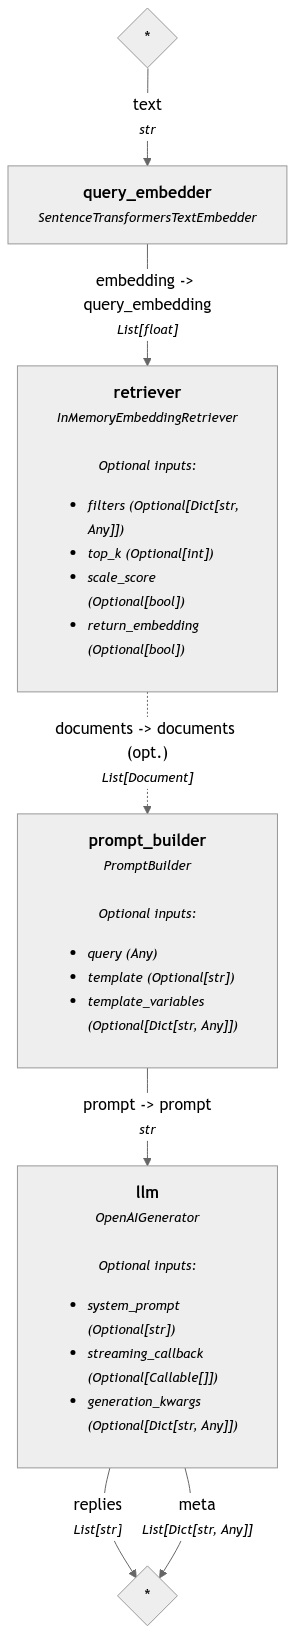

In [17]:
rag.show()

In [18]:
query = "Who is J. R.R. Tolkien?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query}},
        include_outputs_from={"retriever"}
)



Batches: 100%|██████████| 1/1 [00:00<00:00, 24.69it/s]


In [19]:
rich.print(result["llm"]["replies"][0])

John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the
most influential and celebrated figures in literary history, particularly within the realm of high fantasy.

In [20]:
query = "Who is Orlando Bloom?"
result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query}},
)

Batches: 100%|██████████| 1/1 [00:00<00:00, 40.81it/s]


In [21]:
rich.print(result["llm"]["replies"][0])

no_answer

### Create Conditional Routes


Now that you got the model to respond with an answer or `no_answer`, you can create pipeline branches that are activated according to this response using the [`ConditionalRouter`](https://docs.haystack.deepset.ai/docs/conditionalrouter?utm_campaign=developer-relations&utm_source=dlai) component for this.

ConditionalRouter routes your data through different paths down the pipeline by evaluating the conditions that you specified.

The following are two different routes that the pipeline can take: if in the reply of the generator, there are the words 'no_answer', then go to the route 'go_to_websearch'. Instead, if 'no_answer' is not in the answer, then give the response and stop the pipeline.

In [22]:
routes = [
    {
        "condition": "{{'no_answer' in replies[0]|lower}}",
        "output": "{{query}}",
        "output_name": "go_to_websearch", 
        "output_type": str,
    },
    {
        "condition": "{{'no_answer' not in replies[0]|lower}}",
        "output": "{{replies[0]}}",
        "output_name": "answer",
        "output_type": str,
    },
]

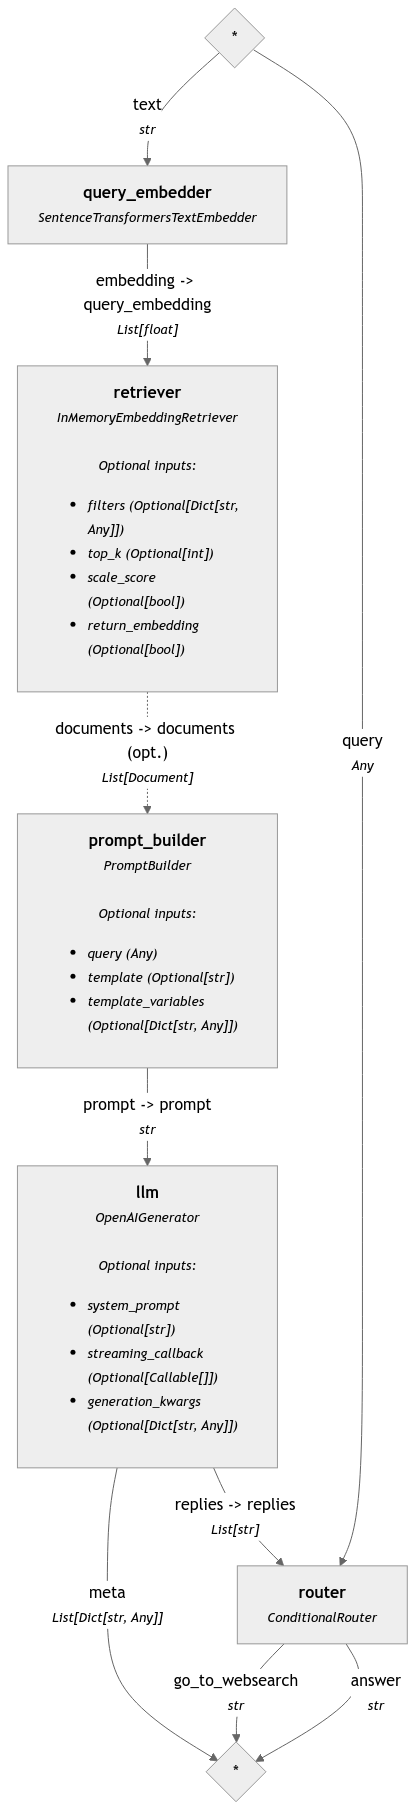

In [23]:
rag.add_component("router", ConditionalRouter(routes=routes))
rag.connect("llm.replies", "router.replies")

rag.show()

In [24]:
query = "Who is Tolkien?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query},
    "router": {"query": query}} # We pass the query to the router because we need it in case we go to websearch
)

result

Batches: 100%|██████████| 1/1 [00:00<00:00, 56.56it/s]


{'llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 50,
     'prompt_tokens': 163,
     'total_tokens': 213,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]},
 'router': {'answer': 'John Ronald Reuel Tolkien, born on January 3, 1892, in Bloemfontein, South Africa, is widely regarded as one of the most influential and celebrated figures in literary history, particularly within the realm of high fantasy.'}}

In [25]:
query = "Who is Orlando Bloom?"

result = rag.run(
    {"query_embedder": {"text": query}, 
    "prompt_builder": {"query": query},
    "router": {"query": query}} # We pass the query to the router because we need it in case we go to websearch
)

result

Batches: 100%|██████████| 1/1 [00:00<00:00, 26.79it/s]


{'llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 3,
     'prompt_tokens': 151,
     'total_tokens': 154,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}]},
 'router': {'go_to_websearch': 'Who is Orlando Bloom?'}}

### Create Websearch Branch


In [26]:
prompt_for_websearch = """
Answer the following query given the documents retrieved from the web.
Your answer should indicate that your answer was generated from websearch.
You can also reference the URLs that the answer was generated from

Query: {{query}}
Documents:
{% for document in documents %}
  {{document.content}}
{% endfor %}
"""

### Build a Pipeline with Conditional Routes

To perform the web search, we use the components SerperDevWebSearch. You need to create an account and use an API token to access. When you give SerperDevWebSearch a query, it returns a list of the URLs most relevant to your search. It uses page snippets (pieces of text displayed under the page title in search results) to find the answers, not the whole pages.

In [27]:
WS_API_TOKEN = os.getenv("WS_API_TOKEN")

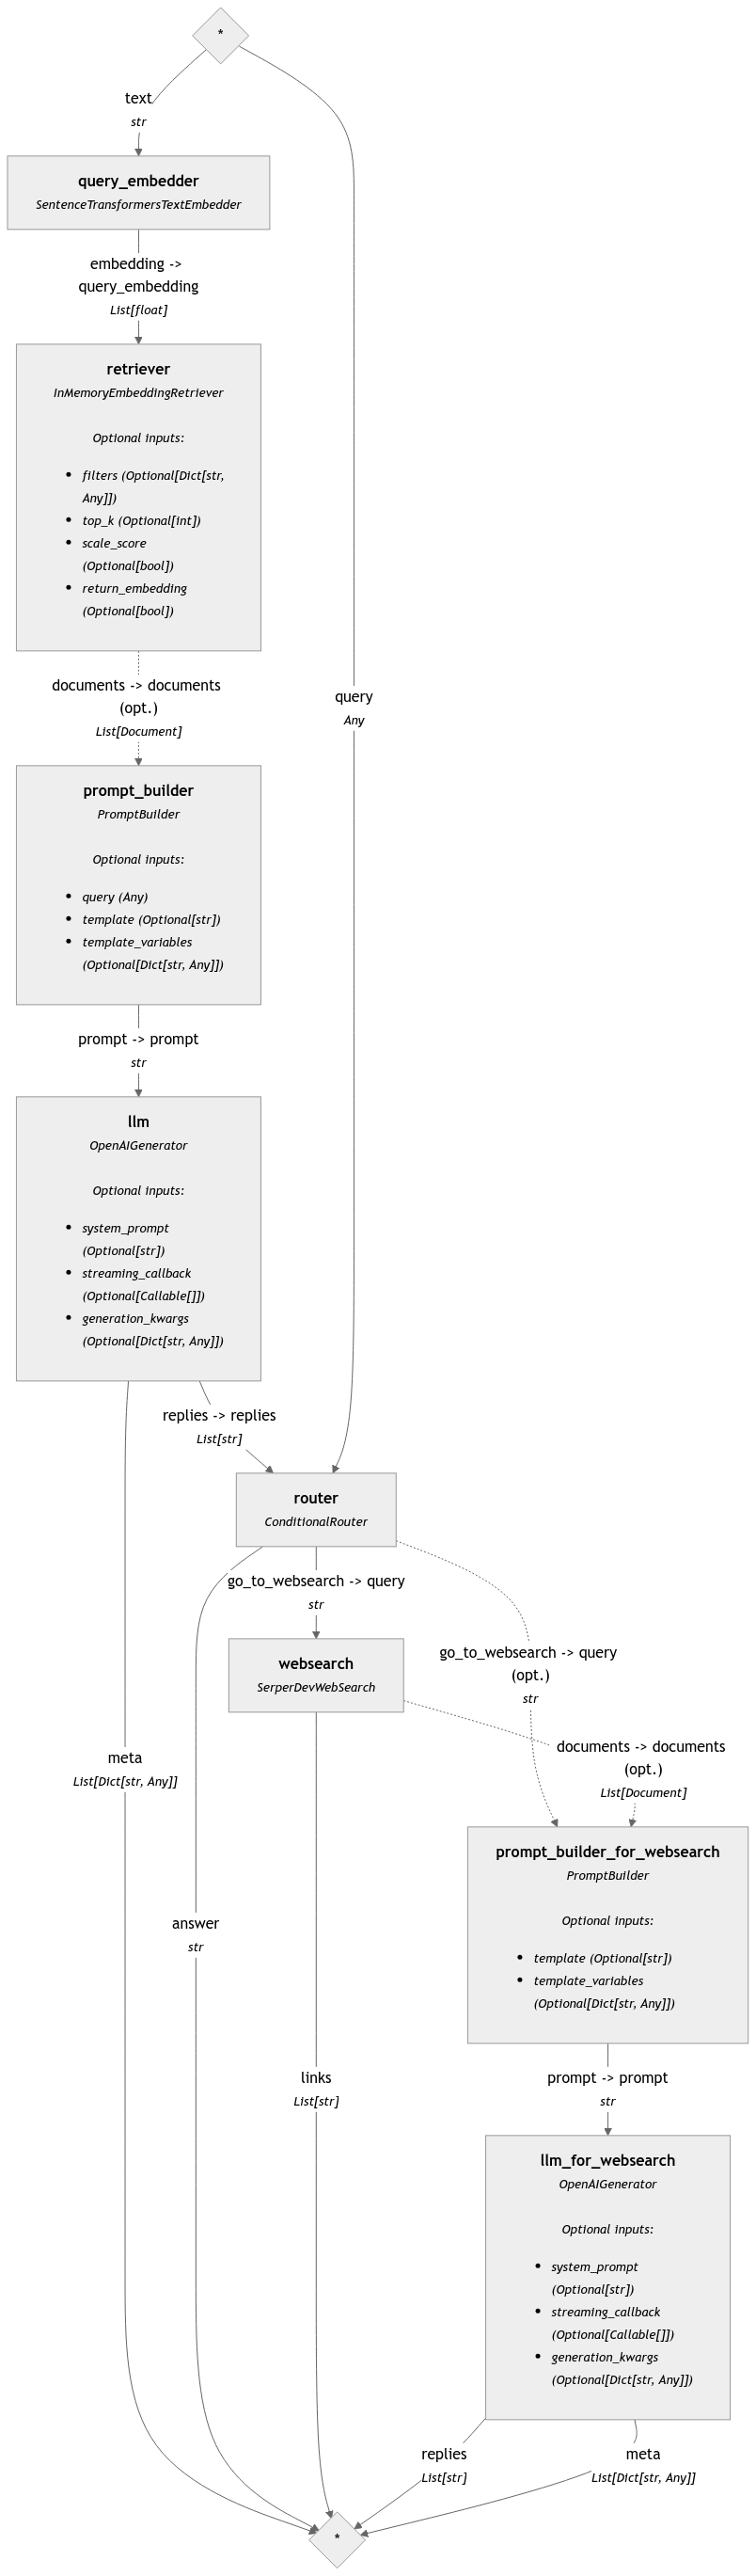

In [29]:
rag_or_websearch = Pipeline()
rag_or_websearch.add_component("query_embedder", SentenceTransformersTextEmbedder("sentence-transformers/all-MiniLM-L6-v2"))
rag_or_websearch.add_component("retriever", InMemoryEmbeddingRetriever(document_store=document_store, top_k = 3))
rag_or_websearch.add_component("prompt_builder", PromptBuilder(template=rag_prompt_template))
rag_or_websearch.add_component("llm", OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN)))
rag_or_websearch.add_component("router", ConditionalRouter(routes))
rag_or_websearch.add_component("websearch", SerperDevWebSearch(api_key=Secret.from_token(WS_API_TOKEN))) 
rag_or_websearch.add_component("prompt_builder_for_websearch", PromptBuilder(template=prompt_for_websearch))
rag_or_websearch.add_component("llm_for_websearch",  OpenAIGenerator(model="gpt-4o-mini-2024-07-18", api_key=Secret.from_token(OPENAI_API_TOKEN)))

rag_or_websearch.connect("query_embedder.embedding", "retriever.query_embedding")
rag_or_websearch.connect("retriever.documents", "prompt_builder.documents")
rag_or_websearch.connect("prompt_builder", "llm")
rag_or_websearch.connect("llm.replies", "router.replies")
rag_or_websearch.connect("router.go_to_websearch", "websearch.query")
rag_or_websearch.connect("router.go_to_websearch", "prompt_builder_for_websearch.query")
rag_or_websearch.connect("websearch.documents", "prompt_builder_for_websearch.documents")
rag_or_websearch.connect("prompt_builder_for_websearch", "llm_for_websearch")

rag_or_websearch.show()

In [30]:
query= "Who is Orlando Bloom?"

result = rag_or_websearch.run({"query_embedder": {"text": query}, 
                      "prompt_builder":{"query": query},
                      "router": {"query": query}},
                      include_outputs_from=["llm", "router", "websearch"])

Batches: 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]


In [31]:
result

{'llm': {'meta': [{'model': 'gpt-4o-mini-2024-07-18',
    'index': 0,
    'finish_reason': 'stop',
    'usage': {'completion_tokens': 3,
     'prompt_tokens': 151,
     'total_tokens': 154,
     'completion_tokens_details': CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0),
     'prompt_tokens_details': PromptTokensDetails(audio_tokens=0, cached_tokens=0)}}],
  'replies': ['no_answer']},
 'websearch': {'links': ['https://en.wikipedia.org/wiki/Orlando_Bloom',
   'https://www.imdb.com/name/nm0089217/',
   'https://www.billboard.com/lists/katy-perry-orlando-bloom-relationship-timeline/',
   'https://www.instagram.com/orlandobloom/?hl=en',
   'https://www.imdb.com/name/nm0089217/bio/',
   'https://www.empireonline.com/people/orlando-bloom/',
   'https://www.rottentomatoes.com/celebrity/orlando_bloom',
   'https://kids.kiddle.co/Orlando_Bloom',
   'https://people.com/tag/orlando-bloom/',
   'https://www.unicef.org/goodwil

In [32]:
rich.print(result['llm']['replies'][0])

no_answer

In [33]:
rich.print(result['llm_for_websearch']['replies'][0])

Orlando Bloom is an English actor born on January 13, 1977, in Canterbury, Kent, England. He is best known for his 
breakthrough role as Legolas, the elven prince, in "The Lord of the Rings" film series, which debuted in 2001. He 
later reprised this role in "The Hobbit" film series. Besides his acting career, Bloom has also served as a UNICEF 
Goodwill Ambassador since 2009, highlighting his commitment to children's rights (sources: various retrieved 
documents). 

For more detailed information, you can check these links:
- [Orlando Bloom Biography](https://www.example1.com)
- [Orlando Bloom's Film Career](https://www.example2.com)